# **Friedman synthetic dataset with concept drifts.**

### Import libraries

In [16]:
import river
from river import datasets
from river import linear_model, tree
from river import drift, metrics
from river.datasets import synth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from frouros.detectors.concept_drift.streaming.window_based.adwin import ADWIN
from frouros.detectors.concept_drift.streaming.statistical_process_control.ddm import DDM
from frouros.detectors.concept_drift.streaming.statistical_process_control.eddm import EDDM
from frouros.detectors.concept_drift.streaming.change_detection.page_hinkley import PageHinkley


### Define the datasets


##### **'lea': Local Expanding Abrupt drift.**
The concept drift appears in two distinct regions of the instance space, while the remaining regions are left unaltered. There are three points of abrupt change in the training dataset. At every consecutive change the regions of drift are expanded.

In [17]:
dataset = synth.FriedmanDrift(drift_type='lea', position=(50, 450, 850), seed=42)


In [18]:
# Print the first 5 samples from the dataset
for x, y in dataset.take(5):
    print(list(x.values()), y)

[0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, 0.029797219438070344] 7.6612066799391085
[0.026535969683863625, 0.1988376506866485, 0.6498844377795232, 0.5449414806032167, 0.2204406220406967, 0.5892656838759087, 0.8094304566778266, 0.006498759678061017, 0.8058192518328079, 0.6981393949882269] 8.330237325619887
[0.3402505165179919, 0.15547949981178155, 0.9572130722067812, 0.33659454511262676, 0.09274584338014791, 0.09671637683346401, 0.8474943663474598, 0.6037260313668911, 0.8071282732743802, 0.7297317866938179] 7.044929465589236
[0.3785343772083535, 0.552040631273227, 0.8294046642529949, 0.6185197523642461, 0.8617069003107772, 0.577352145256762, 0.7045718362149235, 0.045824383655662215, 0.22789827565154686, 0.28938796360210717] 18.160369621840488
[0.0797919769236275, 0.23279088636103018, 0.10100142940972912, 0.2779736031100921, 0.6356844442644002, 0.

### Convert to DataFrame

In [19]:
data = [dict(x, **{'y': y}) for x, y in dataset.take(1000)]  # Take 1000 samples for example
df = pd.DataFrame(data)
X = df.drop(columns=['y'])
y = df['y']

In [20]:
print(X.head)

<bound method NDFrame.head of             0         1         2         3         4         5         6  \
0    0.639427  0.025011  0.275029  0.223211  0.736471  0.676699  0.892180   
1    0.026536  0.198838  0.649884  0.544941  0.220441  0.589266  0.809430   
2    0.340251  0.155479  0.957213  0.336595  0.092746  0.096716  0.847494   
3    0.378534  0.552041  0.829405  0.618520  0.861707  0.577352  0.704572   
4    0.079792  0.232791  0.101001  0.277974  0.635684  0.364832  0.370181   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.922354  0.886595  0.965236  0.942846  0.198462  0.972428  0.751850   
996  0.970325  0.309274  0.765823  0.801490  0.458714  0.165342  0.000843   
997  0.203322  0.090167  0.244733  0.684714  0.845668  0.374258  0.477344   
998  0.698780  0.912833  0.668437  0.831347  0.706224  0.763056  0.095825   
999  0.819791  0.730372  0.424592  0.393850  0.071657  0.488309  0.740429   

            7         8         9  
0    0.08

In [21]:
print(y.head)

<bound method NDFrame.head of 0       7.661207
1       8.330237
2       7.044929
3      18.160370
4       8.906078
         ...    
995    19.121370
996    20.456076
997     6.508613
998    21.799763
999    11.819080
Name: y, Length: 1000, dtype: float64>


In [22]:
null_values = X.isnull().sum()
print(null_values)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64


### Visualize basic statistics and relationships between features and the target variable using a pairplot.

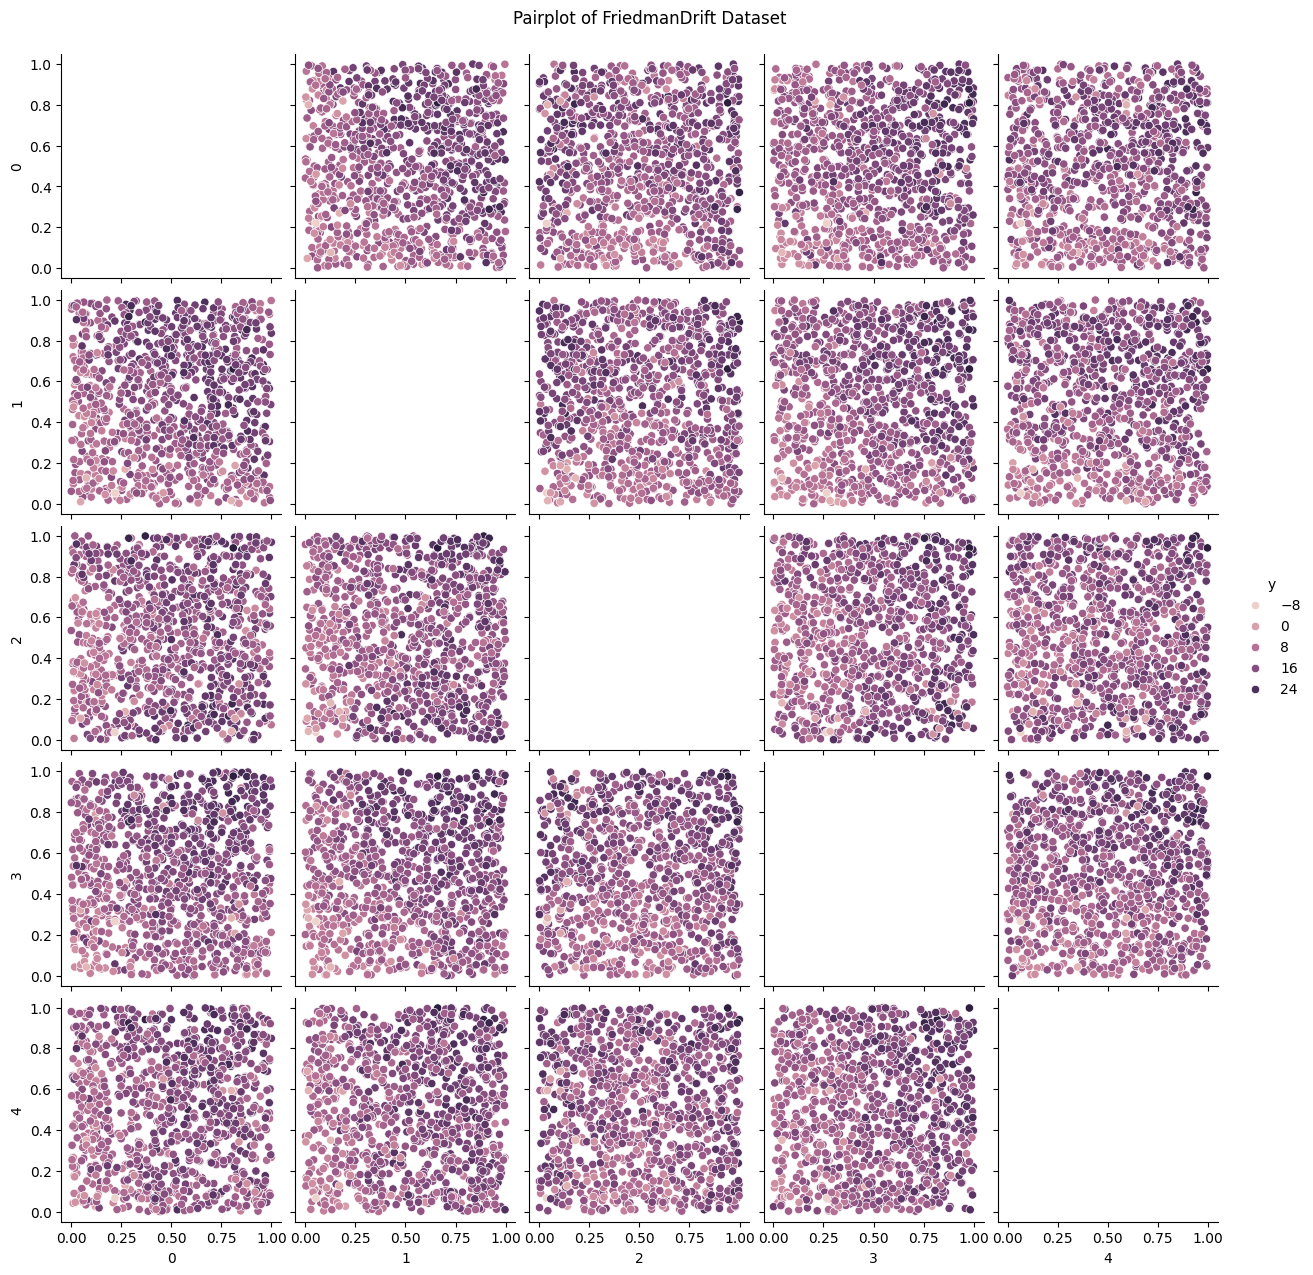

In [23]:
# Pairplot to visualize relationships between features and the target variable
sns.pairplot(df, vars=df.columns[:5], hue='y')
plt.suptitle('Pairplot of FriedmanDrift Dataset', y=1.02)
plt.show()


### Visualize how the target variable changes over time to understand the concept drift.

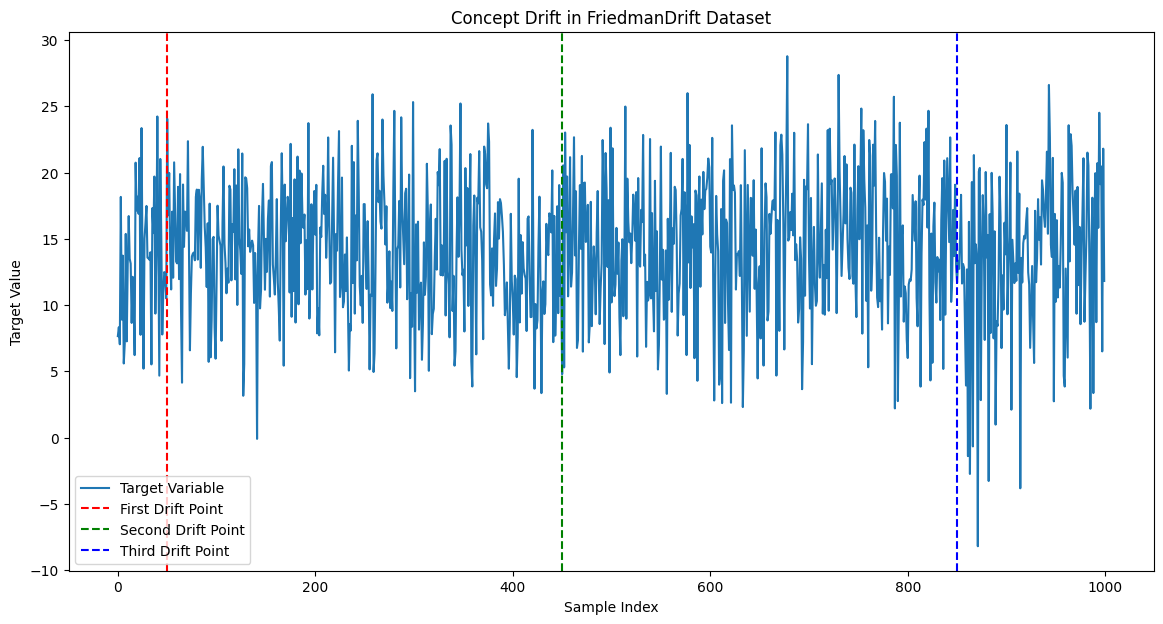

In [24]:
# Plot the target variable over time to visualize concept drift
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['y'], label='Target Variable')
plt.axvline(x=50, color='r', linestyle='--', label='First Drift Point')
plt.axvline(x=450, color='g', linestyle='--', label='Second Drift Point')
plt.axvline(x=850, color='b', linestyle='--', label='Third Drift Point')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Concept Drift in FriedmanDrift Dataset')
plt.legend()
plt.show()


### visualize how individual features change over time, especially the relevant ones (first 5 features):

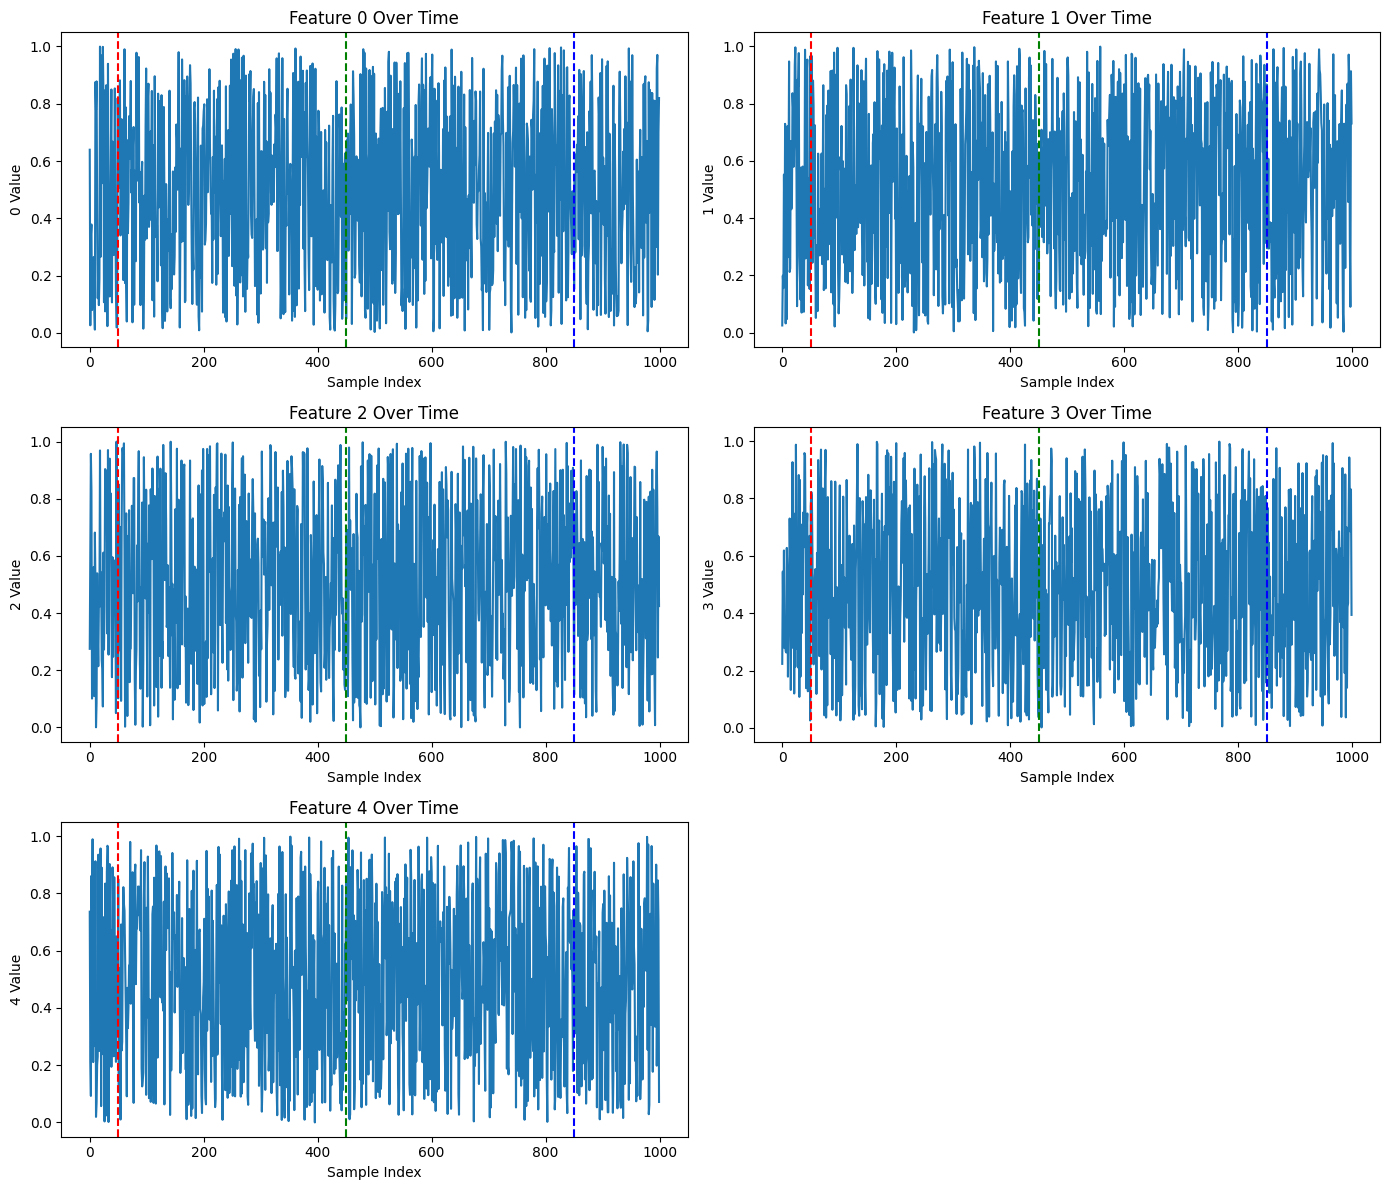

In [26]:
# Plot the first 5 features over time to visualize their behavior
plt.figure(figsize=(14, 12))
for i, column in enumerate(df.columns[:5], 1):
    plt.subplot(3, 2, i)
    plt.plot(df.index, df[column])
    plt.axvline(x=50, color='r', linestyle='--', label='Drift Point' if i == 1 else "")
    plt.axvline(x=450, color='g', linestyle='--', label='Drift Point' if i == 1 else "")
    plt.axvline(x=850, color='b', linestyle='--', label='Drift Point' if i == 1 else "")
    plt.title(f'Feature {column} Over Time')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{column} Value')
    
plt.tight_layout()
plt.show()


### Train-Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define machine learning algorithms

In [28]:
model = SVR()

### Train the Model

In [29]:
model.fit(X_train, y_train)

SVR()

### Evaluate the Model

In [30]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
# Calculate R² score
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 7.393716322329777
R² Score: 0.7535914722540021


**MSE indicates the average squared difference between the model's predictions and the actual target values.
R² Score of indicates how much of the variation of a dependent variable is explained by an independent variable in a regression model.**

### Define drift detection algorithms

In [31]:
dd = DDM()

### Simulate Data Stream and Check for Drift

In [34]:
# Iterate through the next 1000 samples and update the DDM detector
for i, (_, row) in enumerate(df.iterrows()):
    true_label = row['y']
    predicted_label = model.predict([row.drop('y').values])[0]  # Predict directly using the row

    # Update DDM with the model's prediction (1 if incorrect, 0 if correct)
    dd.update(value=int(predicted_label != true_label))

    # Check for drift
    if dd.drift:
        print(f'Change detected at index {i + train_indices}')
        break  # Stop if a drift is detected
    elif dd.warning:
        print(f'Warning detected at index {i + train_indices}')